# Watts Next


## Introduction

## Objectives

### Description Objective:

1. What are the key characteristics of households with the highest annual electricity usage?
2. How does the household size or structure correlate with electricity consumption?
3. Are there regional patterns in electricity consumption that can be identified in the dataset?
4. Which household appliances are the most significant contributors to overall electricity usage?
5. How do the building characteristics (age, type, insulation) relate to electricity usage?

### Feature Selection Objective

1. Among the myriad of features available, which ones are the most predictive of a household's annual electricity usage?
2. Can reducing the feature space improve model interpretability without compromising the predictive power?
3. How does the inclusion of certain types of data (demographic, building features, appliance usage) affect the model's performance?

### Prediction Objective

1. How accurately can we predict a household's annual electricity usage based on the selected features?
2. Which predictive models perform best for this particular dataset and target variable?
3. How do different machine learning models handle the variability in the electricity consumption?
4. Can we identify a model that provides the best interpretability for stakeholders?


## Test Connection to Database (MS SQL Server Management Studio)

We can use in-database Machine Learning Services to be able to play with data and create models.
but for now i will use the data from the database to create a model using python just to show how it can be done.


In [1]:
import pyodbc
import sys

server = 'DESKTOP-J2H73HI\MSSQLSERVERINST'  # e.g., 'localhost\\SQLEXPRESS' or 'myserver.database.windows.net'
database = 'WattsNext'  # e.g., 'mydatabase'
username = 'your_username'  # If using SQL Server authentication
password = 'your_password'  # If using SQL Server authentication

# If using Windows Authentication, your connection string will be
connection_string = f'DRIVER={{SQL Server}};SERVER={server};DATABASE={database};Trusted_Connection=yes;'

# If using SQL Server Authentication, your connection string will be
# connection_string = f'DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password}'

In [2]:
conn = pyodbc.connect(connection_string)

In [3]:
import pandas as pd

query = 'SELECT * FROM recs2009_public'  
df = pd.read_sql(query, conn)

C:\Users\User\AppData\Local\Temp\ipykernel_36376\1054043184.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


In [4]:
df.head() # print the first 5 rows of the dataframe

,"""DOEID""","""REGIONC""","""DIVISION""","""REPORTABLE_DOMAIN""","""TYPEHUQ""","""NWEIGHT""","""HDD65""","""CDD65""","""HDD30YR""","""CDD30YR""",...,"""SCALEKER""","""IECC_Climate_Pub""","""HDD50""","""CDD80""","""GND_HDD65""","""WSF""","""OA_LAT""","""GWT""","""DesignDBT99""","""DesignDBT1"""
0,00001,2,4,12,2,2471.68,4742,1080,4953,1271,...,-2,"""4A""",2117,56,4250,0.48,6,56,9,96
1,00002,4,10,26,2,8599.17,2662,199,2688,143,...,-2,"""3C""",62,26,2393,0.61,0,64,38,73
2,00003,1,1,1,5,8969.92,6233,505,5741,829,...,-2,"""5A""",2346,49,5654,0.48,3,52,12,88
3,00004,2,3,7,2,18003.64,6034,672,5781,868,...,-2,"""5A""",2746,0,4941,0.55,4,55,7,87
4,00005,1,1,1,3,5999.61,5388,702,5313,797,...,-2,"""5A""",2251,0,5426,0.61,4,50,13,90


In [11]:
# conn.close() # close the connection

---


## Understanding Data

### Loading Data


In [4]:
import pyodbc # Use the pyodbc driver to connect to an SQL database from Python code.

import pandas as pd
from pandas import set_option
from pandas import get_dummies
import numpy as np
import os

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import seaborn as sns
import scipy.stats

In [2]:

df = pd.read_csv('./RECS_2009/recs2009_public.csv', low_memory=False)

#### Connect to DB


In [6]:
server = 'DESKTOP-J2H73HI\MSSQLSERVERINST'  
database = 'WattsNext'  

# If using Windows Authentication, your connection string will be
connection_string = f'DRIVER={{SQL Server}};SERVER={server};DATABASE={database};Trusted_Connection=yes;'

conn = pyodbc.connect(connection_string)

In [7]:
query = 'SELECT * FROM recs2009_public'  
df = pd.read_sql(query, conn)

C:\Users\User\AppData\Local\Temp\ipykernel_36376\3774483019.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


In [22]:
cursor = conn.cursor()
cursor.execute("SELECT TABLE_NAME FROM INFORMATION_SCHEMA.TABLES WHERE TABLE_TYPE = 'BASE TABLE'")
# Fetch and print table names
tables = cursor.fetchall()
for table in tables:
    print(table[0])

# Close the connection
cursor.close()


recs2009_public
sandbox_recs2009
DevSandboxDatabase


#### Create Sandbox table in database

Duplicate a table within database to create a "sandbox" version while preserving the original table.


In [ ]:
cursor = conn.cursor()
cursor.execute("""
    SELECT * 
    INTO sandbox_recs2009  
    FROM recs2009_public; 
""")
conn.commit()  # Important to commit the change

In [9]:
query = 'SELECT * FROM sandbox_recs2009'  
df = pd.read_sql(query, conn)

C:\Users\User\AppData\Local\Temp\ipykernel_36376\3601928477.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


### Exploratory Data Analysis (EDA)

In the EDA phase, summarizing the main characteristics of a dataset to determine if we need to preprocess the data or not to check the following:

1. data dimensionality (or shape) alongwith observing first few observations of the dataset
2. data types (whether categorical or numerical)
3. generate summary statistics
4. missing values
5. explore our target variable 'KWH' and its possible predictors from the dataset
6. detect outliers and anomalies
7. explore additional predictor variables


#### Understanding the Dataset Structure

data dimensionality (or shape) alongwith observing first few observations of the dataset, as the data is too large to be displayed in a single view, we will take a sample of the data to understand its structure.


In [5]:
df.head() # print the first 5 rows of the dataframe

,DOEID,REGIONC,DIVISION,REPORTABLE_DOMAIN,TYPEHUQ,NWEIGHT,HDD65,CDD65,HDD30YR,CDD30YR,...,SCALEKER,IECC_Climate_Pub,HDD50,CDD80,GND_HDD65,WSF,OA_LAT,GWT,DesignDBT99,DesignDBT1
0,1,2,4,12,2,2471.68,4742,1080,4953,1271,...,-2,4A,2117,56,4250,0.48,6,56,9,96
1,2,4,10,26,2,8599.17,2662,199,2688,143,...,-2,3C,62,26,2393,0.61,0,64,38,73
2,3,1,1,1,5,8969.92,6233,505,5741,829,...,-2,5A,2346,49,5654,0.48,3,52,12,88
3,4,2,3,7,2,18003.64,6034,672,5781,868,...,-2,5A,2746,0,4941,0.55,4,55,7,87
4,5,1,1,1,3,5999.61,5388,702,5313,797,...,-2,5A,2251,0,5426,0.61,4,50,13,90


In [6]:

df.tail() # print the last 5 rows of the dataframe

,DOEID,REGIONC,DIVISION,REPORTABLE_DOMAIN,TYPEHUQ,NWEIGHT,HDD65,CDD65,HDD30YR,CDD30YR,...,SCALEKER,IECC_Climate_Pub,HDD50,CDD80,GND_HDD65,WSF,OA_LAT,GWT,DesignDBT99,DesignDBT1
12078,12079,2,3,9,2,10219.80,7671,332,7784,451,...,-2,6A-6B,4289,39,7819,0.59,0,48,-3,84
12079,12080,3,7,21,4,8689.07,2085,2844,2520,2286,...,-2,3B-4B,360,393,1869,0.50,0,56,26,101
12080,12081,2,4,10,2,4697.21,7935,472,8074,600,...,-2,6A-6B,4494,22,8477,0.58,1,46,-9,89
12081,12082,4,8,23,2,13155.68,5834,770,5989,957,...,-2,5B-5C,2840,0,9010,0.54,1,53,13,93
12082,12083,4,10,26,2,7703.43,2806,124,2859,139,...,-2,3C,92,0,3048,0.53,0,60,44,75


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12083 entries, 0 to 12082
Columns: 940 entries, DOEID to DesignDBT1
dtypes: float64(50), int64(885), object(5)
memory usage: 86.7+ MB


In [8]:
print(df.columns.tolist()[:5]) # Columns names of the dataframe as a list

['DOEID', 'REGIONC', 'DIVISION', 'REPORTABLE_DOMAIN', 'TYPEHUQ']


In [10]:
print(f"Shape of the dataset df_recs is {df.shape}")

Shape of the dataset df_recs is (12083, 940)


Dataset consists of 12084 observation and 940 features.


In [11]:
num_features = df.dtypes[df.dtypes != "object"].index
print("Number of Numerical features: ", len(num_features))

cat_features = df.dtypes[df.dtypes == "object"].index
print("Number of Categorical features: ", len(cat_features))

Number of Numerical features:  935
Number of Categorical features:  5


There are 12084 observations and 940 features in the dataset it's hard to identify datatypes for all features correctly to visualize them also dealing with missing values. I need to understand impertant features to my objective and select them for further analysis.

Feature visualization is a helpful technique that can provide a clear and comprehensive understanding of the feature space; however, feature visualization is not an easy task because usually, the feature space is very high dimensional, So, instead of visualizing the feature space at one time, it is recommended to analyze the pair-wise correlations through exploratory data analytics (EDA) [[26](https://www.sciencedirect.com/science/article/pii/S2210670717317018)].

there are some methods to select important features like Fearure Selection, Feature Importance, PCA, and Correlation Matrix, but i will start with filter based on domain knowledge to focus on the most relevant aspects of data:

- Identify variables that are known to influence energy consumption from industry knowledge, previous research, or expert consultation.
- How do i identify which feature is numerical and which is categorial if i have huge dataset?

  - Look for the dictionary and codebook for the data which is a documentation that explains each feature, including whether it's numerical (continuous or discrete) or categorical (nominal or ordinal).

- Exclude variables that are unlikely to have any relationship with energy consumption.

If the number of features is still substantial, then consider the more advanced feature selection techniques.


#### Segregation into Separate DataFrames


In [18]:
# List of Nominal Categorical Features based on the cell above
nominal_categorical_features = [
    'REPORTABLE_DOMAIN', 
    'TYPEHUQ', 
    'Climate_Region_Pub', 
    'UR', 
    'CONDCOOP', 
    'WALLTYPE', 
    'ROOFTYPE', 
    'STUDIO', 
    'STORIES',
    'CELLAR',
    'BASEFIN',
    'BASEHEAT', 
    'BASEHT2', 
    'BASECOOL', 
    'BASECL2',   
    'BASEUSE', 
    'ATTIC', 
    'ATTICFIN', 
    'ATTCHEAT', 
    'ATTCHT2', 
    'ATTCCOOL', 
    'ATTCCL2',  
    'PRKGPLC1', 
    'GARGLOC',  
    'GARGHEAT', 
    'GARGCOOL', 
    'PRKGPLC2',
    'MICRO', 
    'COFFEE',
    'TOPGRILL', 
    'STGRILA', 
    'TOASTER', 
    'ESFRIG',  
    'ESFRIG2', 
    'ESFRIG3', 
    'DISHWASH',
    'CWASHER',
    'DRYER',
    'TVTYPE1', 
    'TVAUDIOSYS1', 
    'PLAYSTA1', 
    'TVTYPE2',
    'TVTYPE3', 
    'PCTYPE1',
    'MONITOR1',  
    'PCTYPE2', 
    'MONITOR2', 
    'WELLPUMP', 
    'SWAMPCOL', 
    'AQUARIUM', 
    'STEREO',
    'SEPFREEZ',
    'HEATHOME', 
    'EQUIPM',  
    'EQUIPAUX', 
    'REVERSE',  
    'WARMAIR', 
    'STEAMR', 
    'PERMELEC', 
    'ROOMHEAT', 
    'RANGE', 
    'DIFEQUIP', 
    'H2OTYPE2',
    'AIRCOND', 
    'COOLTYPE',
    'NOTMOIST',
    'SWIMPOOL', 
    'POOL', 
    'EQUIPAGE',
    'RECBATH', 
    'ADQINSUL', 
    'AUDIT',
    'USEEL',   
    'USESOLAR', 
    'ELECAUX', 
    'ELCOOL',  
    'ELWATER', 
    'ELFOOD', 
    'ELOTHER', 
    'SOLWARM', 
    'SOLARAUX',
    'SOLWATER', 
    'SOLOTHER',  
    'ONSITE', 
    'ONSITEGRID',  
    'HBUSNESS',
    'IECC_Climate_Pub'
]

In [19]:
numerical_discrete_features = [
    'NAPTFLRS',
    'SIZRFRI1',
    'SIZEOFGARAGE',
    'SIZEOFDETACH',
    'BEDROOMS',
    'NCOMBATH',
    'NHAFBATH',
    'OTHROOMS',
    'TOTROOMS',
    'FINBASERMS', 
    'NUMPC',
    'PCPRINT',
    'TVCOLOR',
    'NUMFREEZ',
    'NUMFRIG',
    'MONRFRI2',
    'SIZFREEZ',
    'SIZFREEZ2',
    'FINATTRMS',
    'STOVEN',
    'STOVE',  
    'OVEN',
    'BATTOOLS',
    'HEATROOM',
    'NUMH2ONOTNK',
    'NUMH2OHTRS',
    'ACROOMS',
    'NUMBERAC',
    'NUMCFAN',
    'YEARMADE',
    'NUMAPTS',
    'NUMFLRS' 
]

In [20]:
numerical_continuous_features = [
    'DOEID',  # Assuming this ID is not used in calculations 
    'TEMPNITEAC',
    'TOTSQFT', 
    'TOTHSQFT',
    'TOTCSQFT',
    'KWH',
    'KWHSPH',
    'KWHCOL',
    'KWHWTH',
    'KWHRFG',
    'KWHOTH',
    'BTUEL',
    'BTUELSPH',
    'BTUELCOL',
    'BTUELWTH', 
    'BTUELRFG',
    'BTUELOTH',
    'DOLLAREL',
    'DOLELSPH',
    'DOLELCOL',
    'DOLELWTH',
    'DOLELRFG',
    'DOLELOTH',
    'TOTALBTU',
    'TOTALBTUSPH',
    'TOTALBTUCOL',
    'TOTALBTUWTH',
    'TOTALBTURFG',
    'TOTALBTUOTH',
    'TOTALDOL',
    'TOTALDOLSPH',
    'TOTALDOLCOL',
    'TOTALDOLWTH',
    'TOTALDOLRFG',
    'TOTALDOLOTH',
    'HDD50',
    'CDD80',
    'GND_HDD65',
    'WSF',
    'OA_LAT',
    'GWT' 
]

create separate DataFrames for each type of feature:


In [21]:
# Create DataFrames for each feature type
df_nominal_categorical = df[nominal_categorical_features]
df_numerical_discrete = df[numerical_discrete_features]
df_numerical_continuous = df[numerical_continuous_features]

Data Type Conversion


In [22]:
# Convert data types for nominal categorical features
df_nominal_categorical = df_nominal_categorical.astype('category')

#  numerical discrete features are integers
df_numerical_discrete = df_numerical_discrete.astype('int')

#  numerical continuous features are floats
df_numerical_continuous = df_numerical_continuous.astype('float')

In [30]:
df_numerical_continuous.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12083 entries, 0 to 12082
Data columns (total 41 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DOEID        12083 non-null  float64
 1   TEMPNITEAC   12083 non-null  float64
 2   TOTSQFT      12083 non-null  float64
 3   TOTHSQFT     12083 non-null  float64
 4   TOTCSQFT     12083 non-null  float64
 5   KWH          12083 non-null  float64
 6   KWHSPH       12083 non-null  float64
 7   KWHCOL       12083 non-null  float64
 8   KWHWTH       12083 non-null  float64
 9   KWHRFG       12083 non-null  float64
 10  KWHOTH       12083 non-null  float64
 11  BTUEL        12083 non-null  float64
 12  BTUELSPH     12083 non-null  float64
 13  BTUELCOL     12083 non-null  float64
 14  BTUELWTH     12083 non-null  float64
 15  BTUELRFG     12083 non-null  float64
 16  BTUELOTH     12083 non-null  float64
 17  DOLLAREL     12083 non-null  float64
 18  DOLELSPH     12083 non-null  float64
 19  DOLE

In [29]:
df_numerical_discrete.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12083 entries, 0 to 12082
Data columns (total 32 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   NAPTFLRS      12083 non-null  int32
 1   SIZRFRI1      12083 non-null  int32
 2   SIZEOFGARAGE  12083 non-null  int32
 3   SIZEOFDETACH  12083 non-null  int32
 4   BEDROOMS      12083 non-null  int32
 5   NCOMBATH      12083 non-null  int32
 6   NHAFBATH      12083 non-null  int32
 7   OTHROOMS      12083 non-null  int32
 8   TOTROOMS      12083 non-null  int32
 9   FINBASERMS    12083 non-null  int32
 10  NUMPC         12083 non-null  int32
 11  PCPRINT       12083 non-null  int32
 12  TVCOLOR       12083 non-null  int32
 13  NUMFREEZ      12083 non-null  int32
 14  NUMFRIG       12083 non-null  int32
 15  MONRFRI2      12083 non-null  int32
 16  SIZFREEZ      12083 non-null  int32
 17  SIZFREEZ2     12083 non-null  int32
 18  FINATTRMS     12083 non-null  int32
 19  STOVEN        12083 non-n

In [28]:
df_nominal_categorical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12083 entries, 0 to 12082
Data columns (total 87 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   REPORTABLE_DOMAIN   12083 non-null  category
 1   TYPEHUQ             12083 non-null  category
 2   Climate_Region_Pub  12083 non-null  category
 3   UR                  12083 non-null  category
 4   CONDCOOP            12083 non-null  category
 5   WALLTYPE            12083 non-null  category
 6   ROOFTYPE            12083 non-null  category
 7   STUDIO              12083 non-null  category
 8   STORIES             12083 non-null  category
 9   CELLAR              12083 non-null  category
 10  BASEFIN             12083 non-null  category
 11  BASEHEAT            12083 non-null  category
 12  BASEHT2             12083 non-null  category
 13  BASECOOL            12083 non-null  category
 14  BASECL2             12083 non-null  category
 15  BASEUSE             12083 non-null  

In [33]:
print(f"Number of missing values in the nominal categorical features: {df_nominal_categorical.isnull().sum().sum()}")
print(f"Number of missing values in the numerical discrete features: {df_numerical_discrete.isnull().sum().sum()}")
print(f"Number of missing values in the numerical continuous features: {df_numerical_continuous.isnull().sum().sum()}")

Number of missing values in the nominal categorical features: 0
Number of missing values in the numerical discrete features: 0
Number of missing values in the numerical continuous features: 0


All selected features have been converted to the appropriate data type, and they don't contain any missing values.


Check for duplicates in the dataset.


In [34]:
print(f"Number of duplicate rows in nominal categorical features: {df_nominal_categorical.duplicated().sum()}")
print(f"Number of duplicate rows in numerical discrete features: {df_numerical_discrete.duplicated().sum()}")
print(f"Number of duplicate rows in numerical continuous features: {df_numerical_continuous.duplicated().sum()}")

Number of duplicate rows in nominal categorical features: 0
Number of duplicate rows in numerical discrete features: 15
Number of duplicate rows in numerical continuous features: 0


In [35]:
# Display duplicate rows
duplicates = df_numerical_discrete[df_numerical_discrete.duplicated()]
print(duplicates)

       NAPTFLRS  SIZRFRI1  SIZEOFGARAGE  SIZEOFDETACH  BEDROOMS  NCOMBATH  \
961           1         3            -2            -2         1         1   
2024         -2         3            -2            -2         3         2   
3350          1         3            -2            -2         2         1   
4472         -2         3            -2            -2         3         2   
5005          1         3            -2            -2         1         1   
7669          1         3            -2            -2         1         1   
7851         -2         4             2            -2         3         2   
8193          1         3            -2            -2         1         1   
8274          1         3            -2            -2         2         1   
8726          1         1            -2            -2        -2         1   
9478         -2         3            -2            -2         2         1   
9993          1         4            -2            -2         1         1   

There are two reasons to not remove duplicates from the dataset:

1. Small Proportion of Data - The number of duplicates is very small compared to the total number of observations in the dataset 15 out of 12084.
2. as the data is collected from different households, it's possible that the same household has been surveyed multiple times(not the same but identical).


#### Checking Outliers

- Outliers can significantly affect statistical analyses and model performance, as they might indicate variability in the data, errors, or novel insights.
- Identifying outliers helps in deciding whether to keep, remove, or transform these values

All data underwent a series of quality control checks and edits to validate the sampled addresses responded to the survey and to identify and resolve data inconsistencies. This process included identifying outliers to numeric items, identifying and resolving logical inconsistencies, and recoding write-in responses into established response categories. [[25](https://www.eia.gov/consumption/residential/data/2020/pdf/2020%20RECS_Methodology%20Brief_v5.pdf)]

EIA subjected the data to more thorough review including outlier checks, reviews of inconsistent responses, analysis of square footage data, interviewer comment review, and updates to household responses from Rental Agent Survey data.[[26](https://www.eia.gov/consumption/residential/methodology/2009/pdf/techdoc-summary010413.pdf)]

**Strategy**
As i have many features, i will start with Early Feature Selection :

- For Numerical features:
  - I will use Pearson correlation coefficient to detect the linear relationship(Direction included) between the features and the target variable.
    - I assumed that the relationship between the features and the target variable is linear based on domain knowledge.
    - in contrast mutual information can detect linear and non linear relationship but it offers a more generalized form of dependency, and also i have already separated the features into numerical and categorical, so the correlation between mix of variable types (continuous and categorical) will not be existed so i assume there is no nonlinear relationship.
    - There is enough data points so the pearson correlation coefficient will be reliable.
    - Also i will show P-Vlaue to check the significance of the correlation.
  - For categorical features:
    - There are many techniques to check the relationship between categorical features and the target variable (main goal is to streamline the dataset by eliminating less informative categorical features):
      - Chi-Square Test
        - Measures the association between each categorical feature and the target variable.
        - If the target variable is continuous, i need to discretized it first.
      - ANOVA
        - Tests the means across different groups (categories) to see if they are significantly different.
        - Suitable for comparing means across multiple groups.
        - Categorical features when the target variable is continuous. Each category of the feature is a group in ANOVA.
      - Mutual Information
        - Measures the amount of information obtained about one random variable by observing another.
        - Suitable For: Both categorical and continuous features and targets.
        - Capable of detecting non-linear relationships.
      - Random Forest/ Gradient Boosting
        - provide feature importance scores, which indicate the contribution of each feature to the model.
        - Suitable For: Both categorical and continuous features and targets.
        - Takes into account the interaction between features and is non-linear.
      - LASSO Regression:
        - Can automatically select and shrink the coefficients of less important features.


In [42]:
import pandas as pd
import scipy.stats

# Assuming 'df_numerical_discrete' is your DataFrame with discrete features and 'df_numerical_continuous' contains the 'KWH' column
# Ensure 'KWH' is a Series and not a DataFrame
target_variable = df_numerical_continuous['KWH']

# Function to calculate Pearson correlation coefficient and p-value
def calculate_pearson_and_pvalue(df, target_series):
    correlations = {}
    p_values = {}

    for column in df.columns:
        corr, p_value = scipy.stats.pearsonr(df[column], target_series)
        correlations[column] = corr
        p_values[column] = p_value

    return correlations, p_values

# Calculate correlations and p-values for numerical discrete features
correlations, p_values = calculate_pearson_and_pvalue(df_numerical_discrete, target_variable)

# Converting to DataFrame for better visualization and sorting
correlation_df = pd.DataFrame.from_dict(correlations, orient='index', columns=['Correlation'])
correlation_df['P-Value'] = pd.DataFrame.from_dict(p_values, orient='index')

# Sorting by correlation
correlation_df = correlation_df.sort_values(by='Correlation', ascending=False)

print(correlation_df)


              Correlation        P-Value
TOTROOMS         0.439167   0.000000e+00
ACROOMS          0.435835   0.000000e+00
NCOMBATH         0.420556   0.000000e+00
BEDROOMS         0.403322   0.000000e+00
HEATROOM         0.390796   0.000000e+00
NUMCFAN          0.383531   0.000000e+00
TVCOLOR          0.371181   0.000000e+00
OTHROOMS         0.354849   0.000000e+00
NUMFRIG          0.302120  1.939397e-253
SIZFREEZ         0.287304  2.510475e-228
NUMFREEZ         0.280999  4.314017e-218
MONRFRI2         0.277001  9.721443e-212
SIZEOFGARAGE     0.259175  1.081648e-184
NUMPC            0.248467  1.969826e-169
SIZRFRI1         0.234271  2.581685e-150
PCPRINT          0.230549  1.644371e-145
OVEN             0.215577  4.854402e-127
YEARMADE         0.212736  1.091232e-123
BATTOOLS         0.179263   8.310028e-88
NUMH2OHTRS       0.168624   9.108999e-78
NHAFBATH         0.168362   1.579690e-77
STOVE            0.160310   2.261802e-70
SIZFREEZ2        0.120580   2.263781e-40
FINBASERMS      

In [43]:
# thresholds
correlation_threshold = 0.3
p_value_threshold = 0.05

# Filter the DataFrame
filtered_features = correlation_df[(correlation_df['Correlation'].abs() >= correlation_threshold) & (correlation_df['P-Value'] <= p_value_threshold)]

# Display the filtered features
print(filtered_features)


          Correlation        P-Value
TOTROOMS     0.439167   0.000000e+00
ACROOMS      0.435835   0.000000e+00
NCOMBATH     0.420556   0.000000e+00
BEDROOMS     0.403322   0.000000e+00
HEATROOM     0.390796   0.000000e+00
NUMCFAN      0.383531   0.000000e+00
TVCOLOR      0.371181   0.000000e+00
OTHROOMS     0.354849   0.000000e+00
NUMFRIG      0.302120  1.939397e-253
NAPTFLRS    -0.332795  2.567505e-310


In [44]:
# Calculate correlations and p-values for numerical continuous features
correlations, p_values = calculate_pearson_and_pvalue(df_numerical_continuous, target_variable)

# Converting to DataFrame for better visualization and sorting
correlation_df = pd.DataFrame.from_dict(correlations, orient='index', columns=['Correlation'])
correlation_df['P-Value'] = pd.DataFrame.from_dict(p_values, orient='index')

# Sorting by correlation
correlation_df = correlation_df.sort_values(by='Correlation', ascending=False)

print(correlation_df)


             Correlation        P-Value
KWH             1.000000   0.000000e+00
BTUEL           1.000000   0.000000e+00
BTUELOTH        0.880403   0.000000e+00
KWHOTH          0.880403   0.000000e+00
DOLLAREL        0.868712   0.000000e+00
DOLELOTH        0.702251   0.000000e+00
TOTALBTUOTH     0.676108   0.000000e+00
TOTALDOLOTH     0.655742   0.000000e+00
BTUELCOL        0.655104   0.000000e+00
KWHCOL          0.655104   0.000000e+00
TOTALBTUCOL     0.655103   0.000000e+00
TOTALBTURFG     0.638621   0.000000e+00
KWHRFG          0.638621   0.000000e+00
BTUELRFG        0.638621   0.000000e+00
TOTALDOL        0.627922   0.000000e+00
TOTALDOLCOL     0.601628   0.000000e+00
DOLELCOL        0.601626   0.000000e+00
KWHWTH          0.585656   0.000000e+00
BTUELWTH        0.585656   0.000000e+00
DOLELWTH        0.514613   0.000000e+00
KWHSPH          0.497684   0.000000e+00
BTUELSPH        0.497684   0.000000e+00
TOTCSQFT        0.484042   0.000000e+00
DOLELSPH        0.452504   0.000000e+00


As most of continous features are related to cost and energy consumption, this is clear as the cost is a result of the energy consumption, so i will focus on the features that are related to the energy consumption and exclude the cost related features.
only target variable KWH from continous features.


For categorical features, i will use Mutual Information to check the relationship between each categorical feature and the target variable.
After selecting the most important features based on mutual information i will use domain knowledge to select the most important features to the target variable.


In [48]:

from sklearn.feature_selection import mutual_info_regression
import pandas as pd


# Convert categorical data to a format suitable for mutual information calculation
df_categorical_encoded = pd.get_dummies(df_nominal_categorical)

# Calculate mutual information
mi_scores = mutual_info_regression(df_categorical_encoded, df_numerical_continuous['KWH'])
mi_scores = pd.Series(mi_scores, index=df_categorical_encoded.columns)

# Sort the features by mutual information
mi_scores = mi_scores.sort_values(ascending=False)

# Set a threshold for mutual information scores
mi_threshold = 0.05

# Filter features that have a score above the threshold
selected_features = mi_scores[mi_scores > mi_threshold].index.tolist()

# Print selected features
print("Selected Features based on MI Score:")
print(selected_features)



Selected Features based on MI Score:
['DRYER_1', 'DRYER_0', 'WELLPUMP_-2', 'PRKGPLC1_-2', 'STUDIO_-2', 'STORIES_-2', 'CWASHER_0', 'CWASHER_1', 'ELWATER_0', 'ELWATER_1', 'COOLTYPE_1', 'STUDIO_0', 'TYPEHUQ_2', 'SWIMPOOL_-2', 'TYPEHUQ_5', 'ROOFTYPE_-2', 'SEPFREEZ_1', 'SEPFREEZ_0', 'TVTYPE3_-2', 'ELFOOD_0', 'ELFOOD_1']


I will remove not applicable features and features that are not related to the target variable.

`DRYER, CWASHER, ELWATER, COOLTYPE, STUDIO, TYPEHUQ, SEPFREEZ, ELFOOD`


Now i made early feature selection for both numerical and categorical features.


In [60]:
# List of selected numerical discrete features based on your output
selected_numerical_discrete_features = [
    "TOTROOMS", "ACROOMS", "NCOMBATH", "BEDROOMS", "HEATROOM",
    "NUMCFAN", "TVCOLOR", "OTHROOMS", "NUMFRIG", "NAPTFLRS"
]

# Create a DataFrame with only the selected numerical discrete features
df_filtered_numerical_discrete = df_numerical_discrete[selected_numerical_discrete_features]

# Display the first few rows of the new DataFrame
df_filtered_numerical_discrete.head()


,TOTROOMS,ACROOMS,NCOMBATH,BEDROOMS,HEATROOM,NUMCFAN,TVCOLOR,OTHROOMS,NUMFRIG,NAPTFLRS
0,9,9,1,4,9,3,4,5,2,-2
1,4,4,2,3,4,0,2,1,1,-2
2,2,-2,1,1,2,1,1,1,1,1
3,7,7,2,3,7,1,5,4,2,-2
4,5,-2,1,2,5,0,2,3,1,-2


In [62]:
# List of selected nominal categorical features
selected_nominal_categorical_features = [
    "DRYER", "CWASHER", "ELWATER", "COOLTYPE", "STUDIO",
    "TYPEHUQ", "SEPFREEZ", "ELFOOD", "REPORTABLE_DOMAIN"
]

# Create a DataFrame with only the selected nominal categorical features
df_filtered_nominal_categorical = df_nominal_categorical[selected_nominal_categorical_features]

# Display the first few rows of the new DataFrame
df_filtered_nominal_categorical.head()


,DRYER,CWASHER,ELWATER,COOLTYPE,STUDIO,TYPEHUQ,SEPFREEZ,ELFOOD,REPORTABLE_DOMAIN
0,1,1,1,1,-2,2,0,1,12
1,1,1,0,1,-2,2,0,0,26
2,0,0,0,2,0,5,0,0,1
3,1,1,1,1,-2,2,0,1,7
4,1,1,0,-2,-2,3,0,1,1


In [52]:
# df_numerical_continuous contains the target variable 'KWH'
df_target = df_numerical_continuous[['KWH']]

# Display the first few rows of the target DataFrame
df_target.head()

,KWH
0,18466.0
1,5148.0
2,2218.0
3,10015.0
4,2869.0


#### Extended Exploratory Data Analysis (EDA)

For Numerical Features:

- Descriptive Statistics: Use measures like mean, median, standard deviation, min, max, quartiles. This helps understand the central tendency and spread of the data.
- Distribution Analysis: Use histograms, density plots, or box plots to understand the distribution of each feature. Look for skewness, peaks, and identify if the data follows a normal distribution or not.
- Relationship Analysis: Scatter plots or pair plots can help identify relationships between numerical features and the target variable.

For Categorical Features:

- Frequency Analysis: Bar charts or count plots to understand the distribution of categories. It helps identify dominant categories, rare categories, or imbalances.
- Association with Target: Use stacked bar charts or group-by summary statistics to see how different categories relate to the target variable.


In [53]:
df_filtered_numerical_discrete.describe()

,TOTROOMS,ACROOMS,NCOMBATH,BEDROOMS,HEATROOM,NUMCFAN,TVCOLOR,OTHROOMS,NUMFRIG,NAPTFLRS
count,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000
mean,5.995283,2.929902,1.672101,2.773070,5.351568,2.115948,2.588182,3.186626,1.265497,-1.269635
std,2.178903,4.230290,0.740713,1.217654,2.624559,2.020352,1.367281,1.397913,0.515308,1.323690
min,1.000000,-2.000000,0.000000,-2.000000,-2.000000,0.000000,0.000000,1.000000,0.000000,-2.000000
25%,5.000000,-2.000000,1.000000,2.000000,4.000000,0.000000,2.000000,2.000000,1.000000,-2.000000
50%,6.000000,4.000000,2.000000,3.000000,5.000000,2.000000,2.000000,3.000000,1.000000,-2.000000
75%,7.000000,6.000000,2.000000,3.000000,7.000000,3.000000,3.000000,4.000000,1.000000,-2.000000
max,23.000000,23.000000,8.000000,13.000000,23.000000,15.000000,14.000000,17.000000,7.000000,3.000000


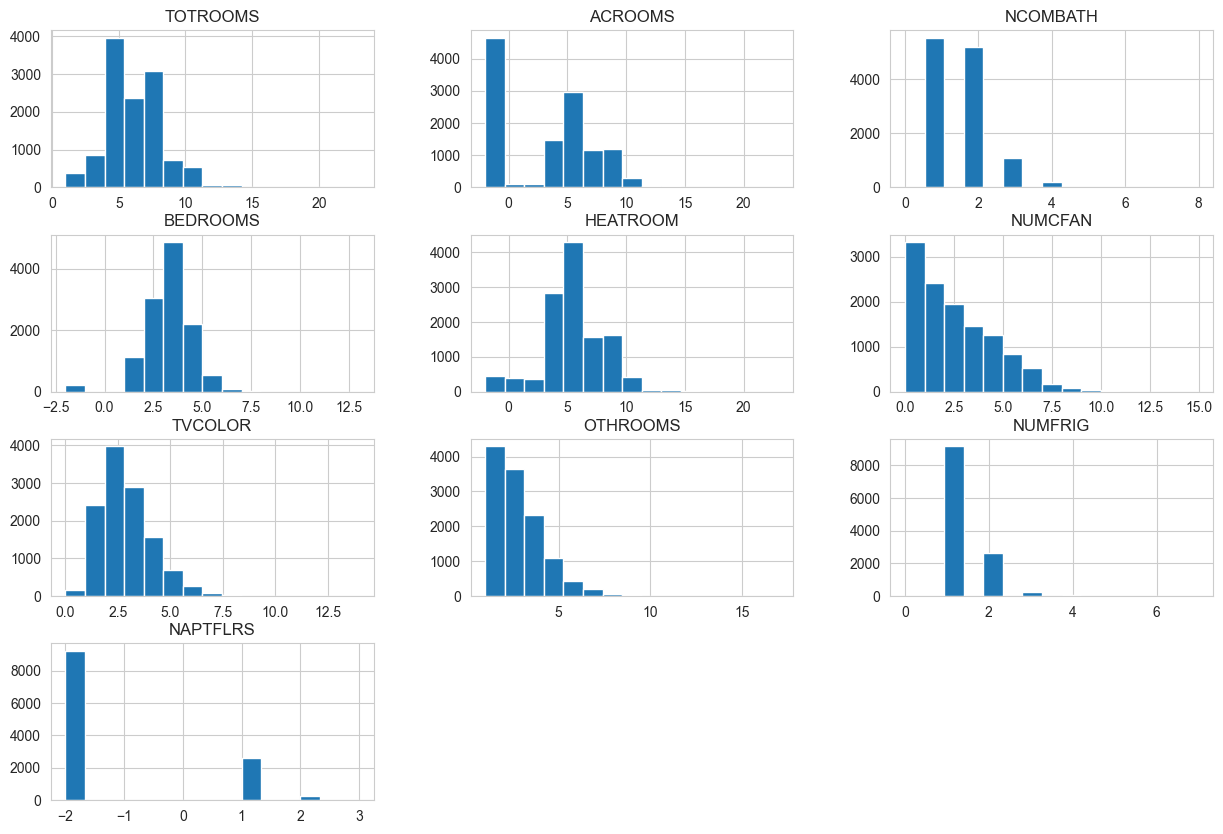

In [67]:

# Histograms for each feature
df_filtered_numerical_discrete.hist(bins=15, figsize=(15, 10))
plt.show()

**Observations**

- TOTROOMS
  - There is a right skew, indicated by a longer tail on the right, meaning there are fewer households with a very high number of rooms.
  - the most common size for a housing unit within the datase is 5 to 6 rooms.
  - most units having a total room count within a couple of rooms from the mean.
  - i have suspicion that the feature follow bimodal distribution, as i observed two peaks in the histogram, indicating two different common types of housing units in the sample, so it's Potential for Segment Analysis, i will segment the data into 'small' and 'large' housing units and analyze their energy consumption patterns separately.
- ACROOMS
  - Mean and median are a little bit far from each other, so the distribution is a little bit skewed to the right.
  - There are high number of values for specific value which deviates from the main cluster of values. which means that this segment may have different characteristics or behaviors than the rest of the population.So i will go with data segmentation, and Analyzing this segment separately to see it can provide insights.
- NCOMBATH
  - The histogram peaks at 1 and 2 full bathrooms, which are the most common configurations.
  - This variable does not seem to follow a normal distribution; it is discrete and has a right skew.
  - there's less variability in the number of bathrooms; most data points are close to the mean.
- BEDROOMS
  - Mean and median are close to each other, so the distribution is not skewed.
  -
- HEATROOM
  - the histogram appears to have a right skew, with a peak around 5-6 rooms heated and fewer observations for higher numbers.
  - A higher standard deviation indicates a wider range of values away from the mean, suggesting diverse heating habits or housing sizes.
- NUMCFAN
  - Mean and median are close to each other, so the distribution is not skewed.
- TVCOLOR
  - Mean and median are close to each other, so the distribution is not skewed.
- OTHROOMS
  - Mean and median are close to each other, so the distribution is not skewed.
- NUMFRIG
  - Mean and median are close to each other, so the distribution is not skewed.
- NAPTFLRS
  - Mean and median are not close to each other, so the distribution is skewed to the right.


**TOTROOMS Segmentation**


Confirm Bimodality, Before segmenting confirm whether the perceived bimodality in the 'TOTROOMS' histogram truly exists using KDE to check for multiple modes in the distribution(Kernel Density Estimate).


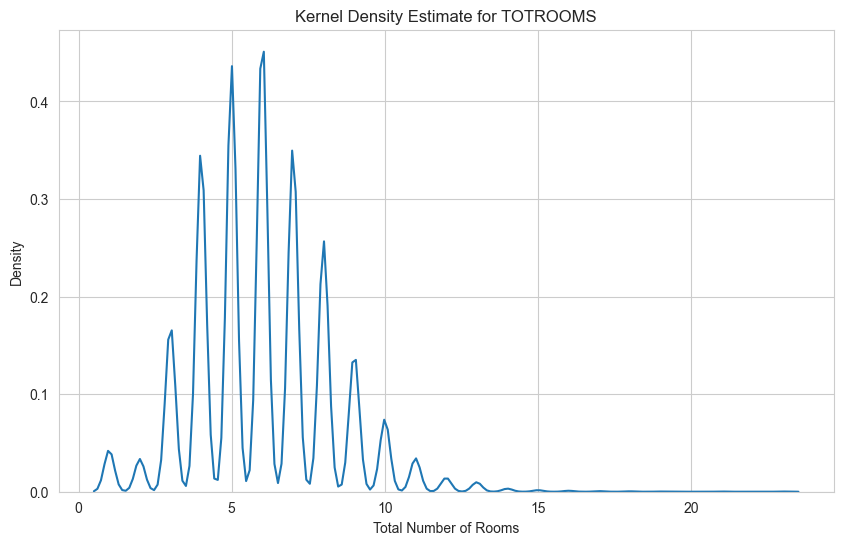

In [134]:
# Kernel Density Estimate (KDE) to check for multiple modes in the distribution
plt.figure(figsize=(10, 6))
sns.kdeplot(df_filtered_numerical_discrete['TOTROOMS'], bw_adjust=0.5)
plt.title('Kernel Density Estimate for TOTROOMS')
plt.xlabel('Total Number of Rooms')
plt.ylabel('Density')
plt.show()

In [137]:
from scipy.stats import kurtosis, skew
# Calculate skewness and kurtosis
data_skewness = skew(df_filtered_numerical_discrete['TOTROOMS'])
data_kurtosis = kurtosis(df_filtered_numerical_discrete['TOTROOMS'], fisher=True)  # Fisher's definition of kurtosis (subtract 3)

print(f"Skewness of TOTROOMS: {data_skewness}")
print(f"Kurtosis of TOTROOMS: {data_kurtosis}")


Skewness of TOTROOMS: 0.5586631779213638
Kurtosis of TOTROOMS: 1.3759081292078408


- due to the discrete nature of the data there are many peaks in the distribution, but i will go with segmentation to get insights related to energy consumption in each segment.
- a moderate right skew in the data, meaning that there are more observations with a lower number of rooms
- a value greater than 1 suggests that the distribution has heavier tails than the normal distribution. This can be indicative of higher probability of extreme values
- The skewness in the data might require transformation (log or square root transformation), to apply models that assume normality


In [138]:
# Define thresholds for small, medium, and large houses
thresholds = {'small': 4, 'medium': 7}

# Segment the data based on the defined thresholds
small_houses = df_filtered_numerical_discrete[df_filtered_numerical_discrete['TOTROOMS'] <= thresholds['small']]
medium_houses = df_filtered_numerical_discrete[(df_filtered_numerical_discrete['TOTROOMS'] > thresholds['small']) & (df_filtered_numerical_discrete['TOTROOMS'] <= thresholds['medium'])]
large_houses = df_filtered_numerical_discrete[df_filtered_numerical_discrete['TOTROOMS'] > thresholds['medium']]


In [140]:
small_houses.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3013 entries, 1 to 12082
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   TOTROOMS  3013 non-null   int32
 1   ACROOMS   3013 non-null   int32
 2   NCOMBATH  3013 non-null   int32
 3   BEDROOMS  3013 non-null   int32
 4   HEATROOM  3013 non-null   int32
 5   NUMCFAN   3013 non-null   int32
 6   TVCOLOR   3013 non-null   int32
 7   OTHROOMS  3013 non-null   int32
 8   NUMFRIG   3013 non-null   int32
 9   NAPTFLRS  3013 non-null   int32
dtypes: int32(10)
memory usage: 141.2 KB


In [144]:
kwh_small_seg = df_target[df_filtered_numerical_discrete['TOTROOMS'] <= thresholds['small']].describe()
kwh_small_seg

,KWH
count,3013.000000
mean,6960.037836
std,4684.763198
min,423.000000
25%,3529.000000
50%,5811.000000
75%,9153.000000
max,54199.000000


In [145]:
medium_houses.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6352 entries, 3 to 12081
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   TOTROOMS  6352 non-null   int32
 1   ACROOMS   6352 non-null   int32
 2   NCOMBATH  6352 non-null   int32
 3   BEDROOMS  6352 non-null   int32
 4   HEATROOM  6352 non-null   int32
 5   NUMCFAN   6352 non-null   int32
 6   TVCOLOR   6352 non-null   int32
 7   OTHROOMS  6352 non-null   int32
 8   NUMFRIG   6352 non-null   int32
 9   NAPTFLRS  6352 non-null   int32
dtypes: int32(10)
memory usage: 297.8 KB


In [146]:


kwh_med_seg = df_target[(df_filtered_numerical_discrete['TOTROOMS'] > thresholds['small']) & (df_filtered_numerical_discrete['TOTROOMS'] <= thresholds['medium'])].describe()
kwh_med_seg

,KWH
count,6352.000000
mean,11437.857053
std,6735.480378
min,67.000000
25%,6466.750000
50%,10124.000000
75%,14812.750000
max,69007.000000


In [147]:
large_houses.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2718 entries, 0 to 12080
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   TOTROOMS  2718 non-null   int32
 1   ACROOMS   2718 non-null   int32
 2   NCOMBATH  2718 non-null   int32
 3   BEDROOMS  2718 non-null   int32
 4   HEATROOM  2718 non-null   int32
 5   NUMCFAN   2718 non-null   int32
 6   TVCOLOR   2718 non-null   int32
 7   OTHROOMS  2718 non-null   int32
 8   NUMFRIG   2718 non-null   int32
 9   NAPTFLRS  2718 non-null   int32
dtypes: int32(10)
memory usage: 127.4 KB


In [148]:
kwh_large_seg = df_target[df_filtered_numerical_discrete['TOTROOMS'] > thresholds['medium']].describe()
kwh_large_seg

,KWH
count,2718.000000
mean,15736.191317
std,9415.250210
min,17.000000
25%,9323.000000
50%,13676.000000
75%,20047.500000
max,150254.000000


<Axes: xlabel='KWH', ylabel='Count'>

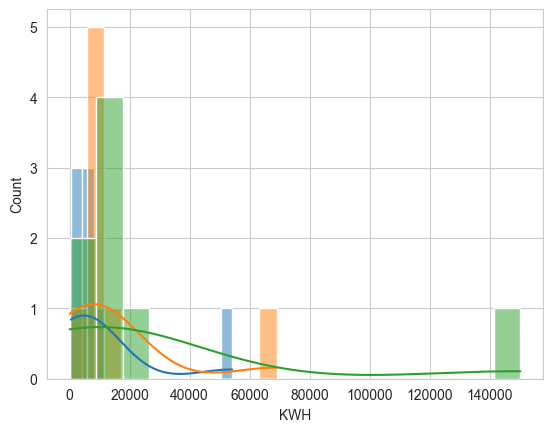

In [149]:
sns.histplot(kwh_small_seg['KWH'], kde=True)
sns.histplot(kwh_med_seg['KWH'], kde=True)
sns.histplot(kwh_large_seg['KWH'], kde=True)

<Axes: >

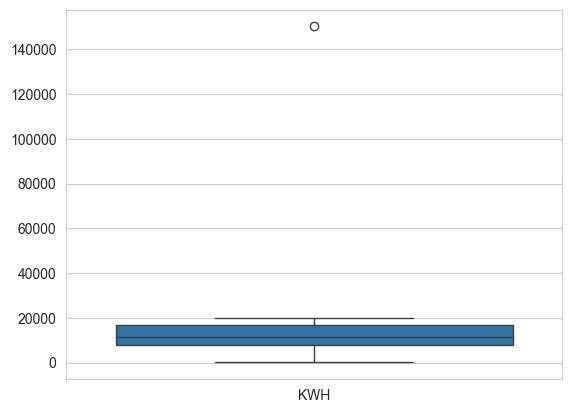

In [150]:
sns.boxplot(data=[kwh_small_seg['KWH'], kwh_med_seg['KWH'], kwh_large_seg['KWH']])


In [151]:
from scipy.stats import f_oneway
f_oneway(kwh_small_seg['KWH'], kwh_med_seg['KWH'], kwh_large_seg['KWH'])

F_onewayResult(statistic=0.5396614577771087, pvalue=0.5908159445227887)

**ACROOMS Segmentation**


In [123]:
# Define a threshold based on ACROOMS histogram observation
threshold = 1   # Less than 1 ACROOMS is considered as a distinct segment

# Create two new DataFrames: one for the main cluster and one for the distinct segment
main_cluster = df_filtered_numerical_discrete[df_filtered_numerical_discrete['ACROOMS'] >= threshold]
distinct_segment = df_filtered_numerical_discrete[df_filtered_numerical_discrete['ACROOMS'] < threshold]


In [124]:
main_cluster.describe()

,TOTROOMS,ACROOMS,NCOMBATH,BEDROOMS,HEATROOM,NUMCFAN,TVCOLOR,OTHROOMS,NUMFRIG,NAPTFLRS
count,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.00000,7436.000000,7436.000000,7436.000000
mean,6.382598,6.010758,1.859602,2.974583,5.944190,2.589430,2.78752,3.387843,1.319661,-1.463825
std,2.134814,2.096885,0.751544,1.103896,2.397876,2.097667,1.39710,1.429230,0.553665,1.184935
min,1.000000,1.000000,0.000000,-2.000000,-2.000000,0.000000,0.00000,1.000000,0.000000,-2.000000
25%,5.000000,5.000000,1.000000,2.000000,5.000000,1.000000,2.00000,2.000000,1.000000,-2.000000
50%,6.000000,6.000000,2.000000,3.000000,6.000000,2.000000,3.00000,3.000000,1.000000,-2.000000
75%,8.000000,7.000000,2.000000,4.000000,7.000000,4.000000,4.00000,4.000000,2.000000,-2.000000
max,23.000000,23.000000,8.000000,8.000000,23.000000,15.000000,14.00000,17.000000,7.000000,3.000000


In [125]:
# Descriptive statistics for the distinct segment
distinct_segment.describe()

,TOTROOMS,ACROOMS,NCOMBATH,BEDROOMS,HEATROOM,NUMCFAN,TVCOLOR,OTHROOMS,NUMFRIG,NAPTFLRS
count,4647.000000,4647.0,4647.000000,4647.000000,4647.000000,4647.000000,4647.000000,4647.000000,4647.000000,4647.000000
mean,5.375511,-2.0,1.372068,2.450613,4.403271,1.358296,2.269206,2.864644,1.178825,-0.958898
std,2.104447,0.0,0.613679,1.317815,2.692613,1.624874,1.254027,1.282340,0.433329,1.467187
min,1.000000,-2.0,0.000000,-2.000000,-2.000000,0.000000,0.000000,1.000000,0.000000,-2.000000
25%,4.000000,-2.0,1.000000,2.000000,3.000000,0.000000,1.000000,2.000000,1.000000,-2.000000
50%,5.000000,-2.0,1.000000,3.000000,5.000000,1.000000,2.000000,3.000000,1.000000,-2.000000
75%,7.000000,-2.0,2.000000,3.000000,6.000000,2.000000,3.000000,3.000000,1.000000,1.000000
max,21.000000,-2.0,7.000000,13.000000,18.000000,10.000000,12.000000,12.000000,4.000000,3.000000


In [126]:
# Subset 'KWH' for the main cluster
main_cluster_target = df_target[df_filtered_numerical_discrete['ACROOMS'] >= threshold]

# Subset 'KWH' for the distinct segment
distinct_segment_target = df_target[df_filtered_numerical_discrete['ACROOMS'] < threshold]

In [127]:
# Descriptive statistics for 'KWH' in the distinct segment
distinct_segment_target.describe()

,KWH
count,4647.000000
mean,8099.782655
std,5936.132929
min,50.000000
25%,4039.000000
50%,6487.000000
75%,10349.500000
max,54338.000000


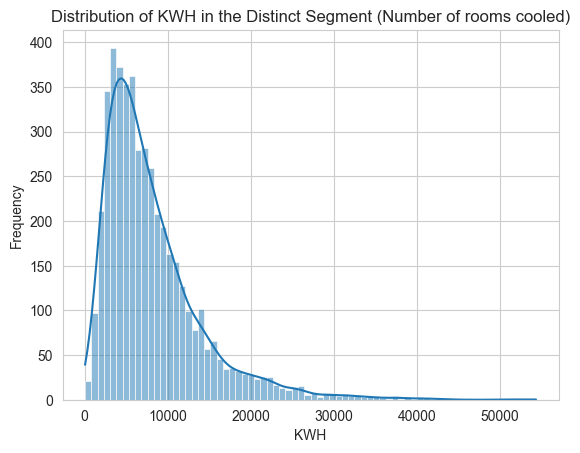

In [131]:
sns.histplot(distinct_segment_target['KWH'], kde=True)
plt.title('Distribution of KWH in the Distinct Segment (Number of rooms cooled)')
plt.xlabel('KWH')
plt.ylabel('Frequency')
plt.show()

- most of the observations have low 'KWH' consumption, but there are a few observations with very high 'KWH' consumption.
- This skewness could be due to several factors such as a small number of large homes or businesses with high energy use within this segment (Number of rooms cooled is 0 or Not applicable) no cooled rooms.


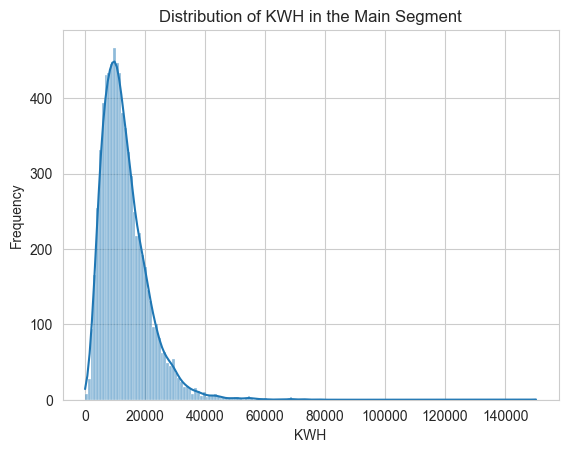

In [129]:
sns.histplot(main_cluster_target['KWH'], kde=True)
plt.title('Distribution of KWH in the Main Segment')
plt.xlabel('KWH')
plt.ylabel('Frequency')
plt.show()

- KWH distribution with number of cooled rooms.


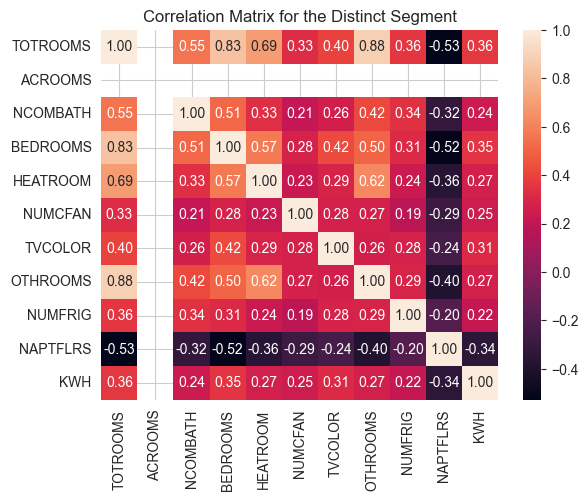

In [130]:
# Merge the distinct segment features with the corresponding 'KWH' values for correlation analysis
distinct_segment_with_target = distinct_segment.join(distinct_segment_target)

# Calculate correlations
correlations_distinct = distinct_segment_with_target.corr()

# Visualize the correlations
sns.heatmap(correlations_distinct, annot=True, fmt=".2f")
plt.title('Correlation Matrix for the Distinct Segment')
plt.show()

TOTROOMS' and 'OTHROOMS' have relatively higher positive correlations with 'KWH', suggesting that as the number of total and other rooms increases, so does energy consumption.


The skewness in 'KWH' consumption and its correlation with 'TOTROOMS' and 'OTHROOMS' suggests that larger homes or businesses are driving the higher energy consumption in this segment.


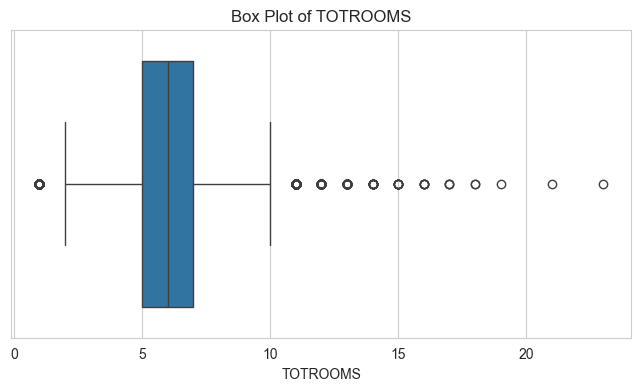

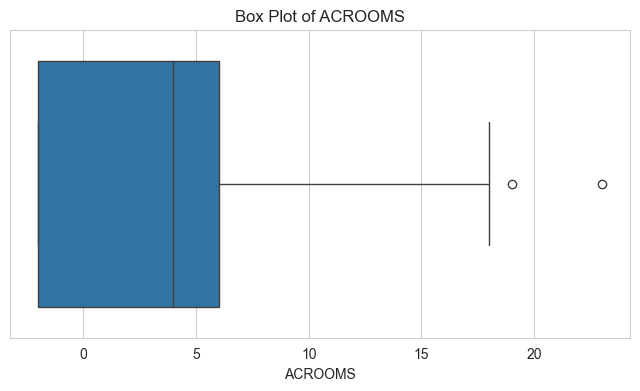

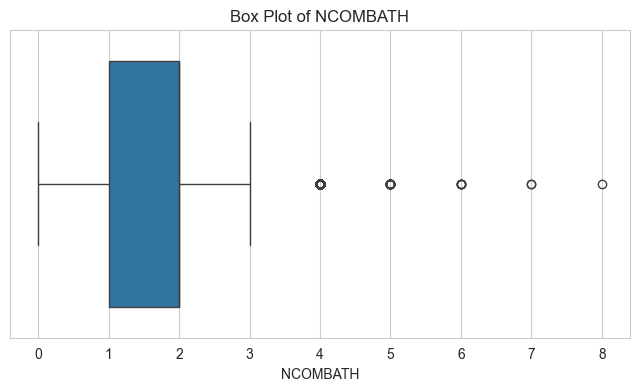

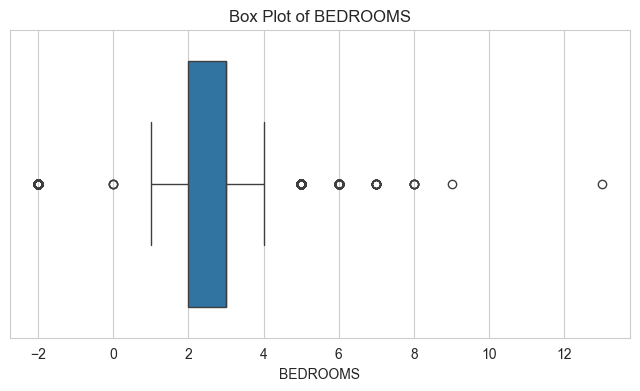

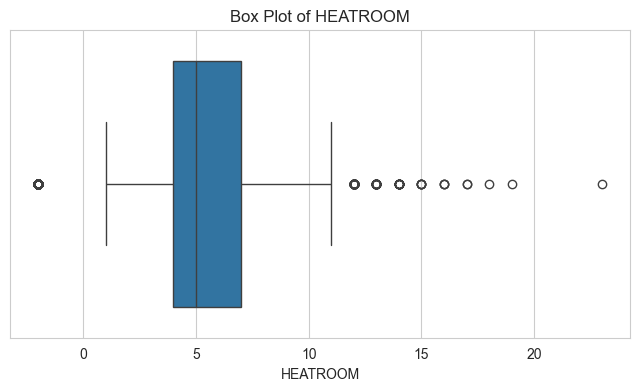

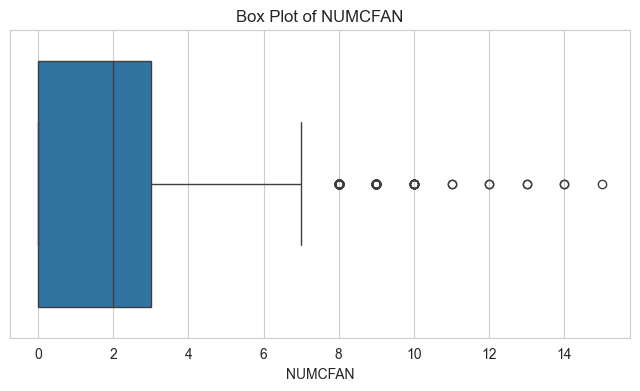

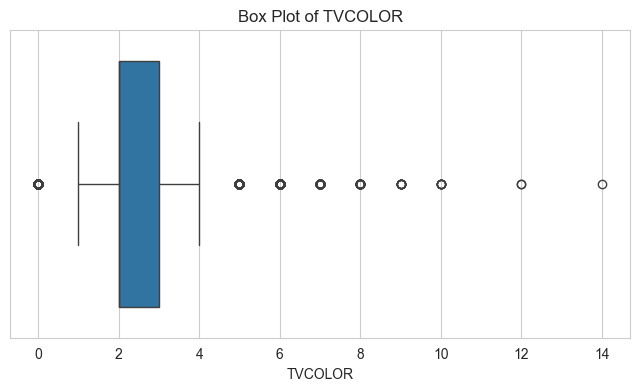

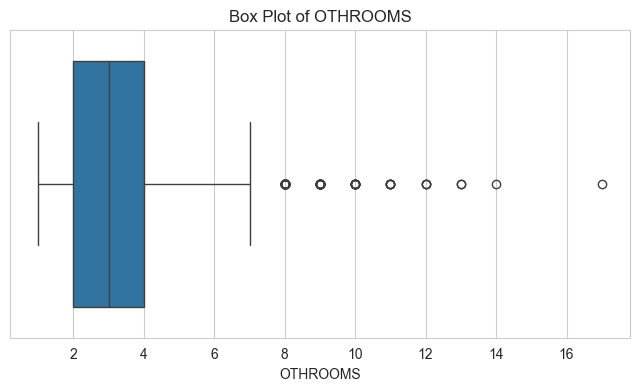

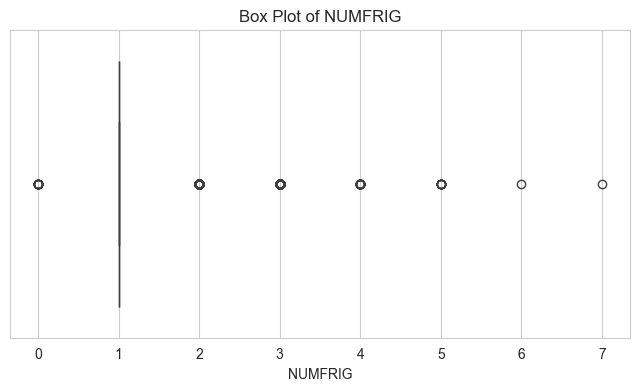

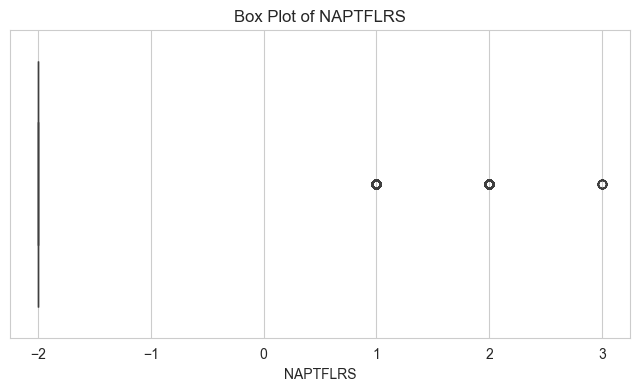

In [69]:
for column in df_filtered_numerical_discrete.columns:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df_filtered_numerical_discrete[column])
    plt.title(f'Box Plot of {column}')
    plt.xlabel(column)
    plt.show()


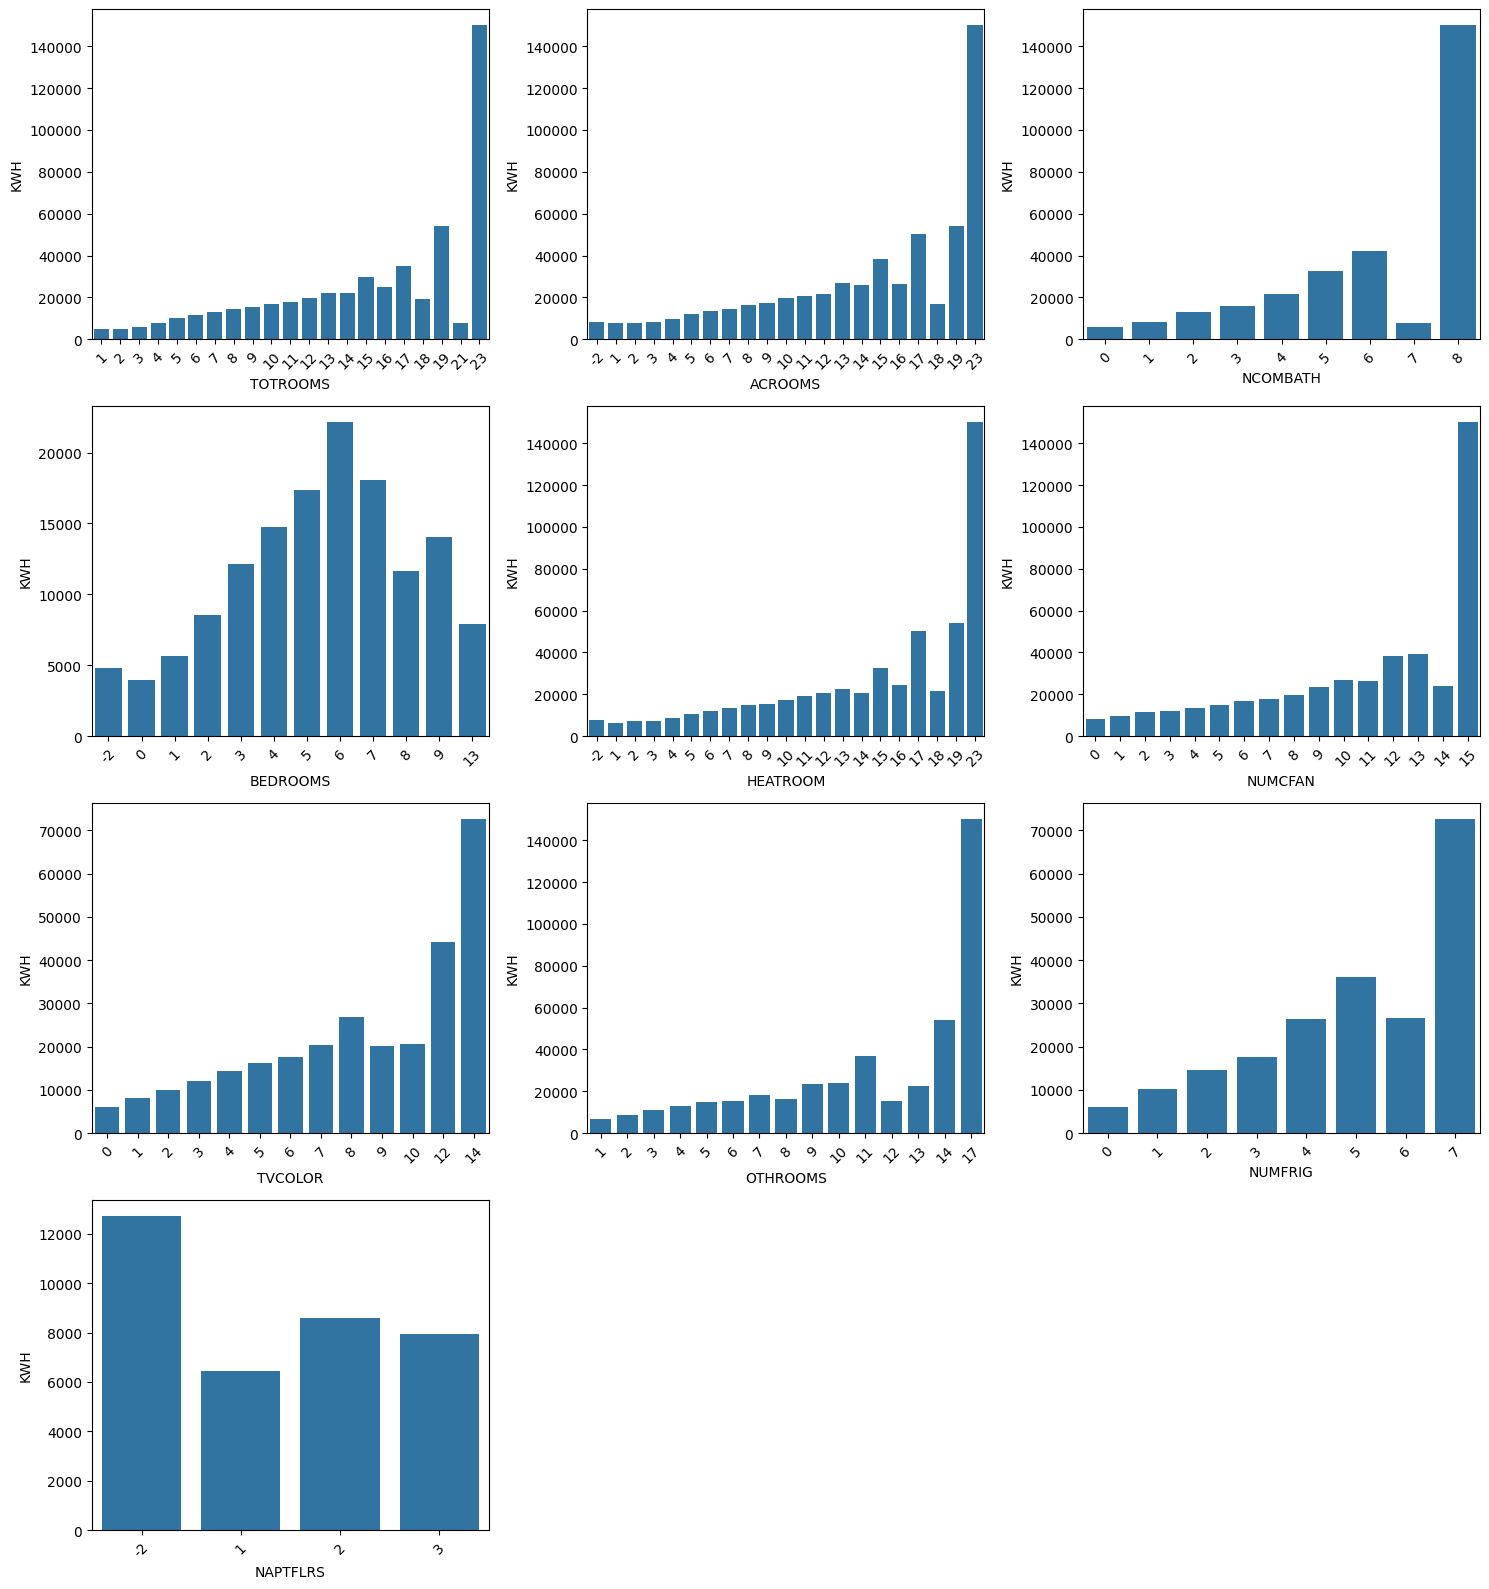

In [58]:


# Number of rows and columns for the subplot grid
n_rows = len(df_filtered_numerical_discrete.columns) // 3 + (len(df_filtered_numerical_discrete.columns) % 3 > 0)
n_cols = 3

# Create a figure with subplots
plt.figure(figsize=(15, n_rows * 4))

for i, column in enumerate(df_filtered_numerical_discrete.columns):
    plt.subplot(n_rows, n_cols, i + 1)
    
    # Merging the feature with the target variable for plotting
    temp_df = pd.concat([df_filtered_numerical_discrete[column], df_target['KWH']], axis=1)
    grouped_data = temp_df.groupby(column).mean().reset_index()

    sns.barplot(x=column, y='KWH', data=grouped_data)
    plt.xticks(rotation=45)
    plt.tight_layout()

plt.show()


In [63]:
df_target.describe()

,KWH
count,12083.000000
mean,11288.159398
std,7641.190845
min,17.000000
25%,5837.000000
50%,9623.000000
75%,14765.000000
max,150254.000000


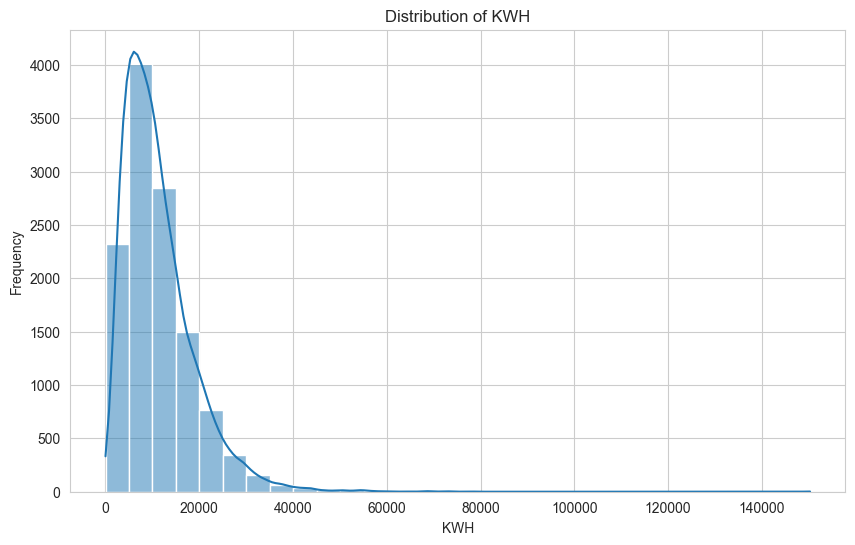

In [71]:


# Assuming df_target is your DataFrame and 'KWH' is the column with the target variable
# Plotting the distribution of 'KWH'
plt.figure(figsize=(10, 6))
sns.histplot(df_target['KWH'], kde=True, bins=30)
plt.title('Distribution of KWH')
plt.xlabel('KWH')
plt.ylabel('Frequency')
plt.show()


Target variable KWH is left skewed, and this is happening because of the outliers.


#### Handling Outliers

When to Start: After getting a sense of the data distribution from EDA, but before any advanced analysis or modeling.
Methodology:
For numerical features, use box plots or Z-scores to identify outliers. Consider using the IQR (Interquartile Range) method.
For handling, you can either remove, cap, or transform outliers, depending on their nature and impact on your analysis. Domain knowledge is crucial here to decide whether an outlier is an anomaly or a valid data point.


#### Correlation Analysis (for Numerical Features)

Understand how different numerical features correlate with each other and with the target variable.
Use heatmaps to visualize correlation matrices. This can highlight multicollinearity issues, which are important to address before modeling.


#### Preprocessing

Scaling/Normalization: For numerical features, especially if you plan to use algorithms sensitive to the scale of data (like KNN, SVM, or neural networks).
Encoding Categorical Data: Convert categorical data into a numerical format suitable for modeling (like one-hot encoding or label encoding).


#### Further Feature Selection/Reduction

Based on insights from EDA and preprocessing, you might identify additional features to drop or transform.
Consider dimensionality reduction techniques (like PCA) if you still have a high number of features.


---


**Insights**

Because Most of data is Zero-inflated (many zero values), that a large number of observations have a value of zero, which could be a legitimate occurrence, but i need to understand whether these zeros are meaningful (true zeros) or if they represent missing or unrecorded events. So i have to analyze each feature individually, especially those with a high number of zeros and skewed distributions.

**Why some features have zeros count?** This is indicative of a situation where no cost was incurred for water heating, likely because it wasn't needed, such as in the summer months, So the distribution of most of the variables is highly skewed to left ( the mean, median, and mode are not equal and are spread out). and to understand such

**How to handle the zero values?** I will handle the zero values in the feature engineering phase, where I will use domain knowledge to decide whether the zeros are valid or whether they should be imputed or transformed.

As there are many features (100 numerical and 840 Categorical) in the dataset, I will focus on the top 10 features that have the highest correlation with the target variable 'KWH'. and i will use the correlation matrix to find the top related features. Steps to follow:

1. Filter Based on Domain Knowledge
   - Identify variables that are known to influence energy consumption from industry knowledge, previous research, or expert consultation.
   - Exclude variables that are unlikely to have any relationship with energy consumption.
2. Correlation Analysis for Numerical Features
   - Perform correlation analysis between each numerical feature and the target variable.
   - Select numerical features with a substantial correlation coefficient (e.g., above 0.3 or below -0.3, though these thresholds can vary based on domain knowledge and the specific context of your analysis).
3. Apply Feature Importance Techniques for Categorical Features
   - Use tree-based models like Random Forest or Gradient Boosting that can handle a large number of categorical features and provide feature importance scores.
   - Keep the categorical features that the model identifies as having the most impact on predicting energy consumption.
4. Dimensionality Reduction on Selected Features
   - Apply PCA or a similar method to the numerical features to create principal components that explain most of the variance.
   - For categorical features, consider using techniques like Multiple Correspondence Analysis (MCA) if PCA is not applicable.
5. Statistical Testing
   - For the remaining features, perform statistical tests (like chi-square tests for categorical variables) to identify which ones have a significant relationship with the target variable.
6. Iterative Modeling and Refinement
   - Build initial models using the selected features and evaluate their performance.
   - Based on the model's performance, iteratively refine the feature set by adding or removing features.

Definition: Outliers are data points that differ significantly from other observations. They can be caused by variability in the measurement or may indicate experimental errors.

Impact: In statistical analyses, outliers can skew results. In machine learning, they can adversely affect the training process, leading to poor model performance.

Identifying Outliers
Visual Methods:

Box Plots: Spotting outliers in numerical data. Points that lie outside the whiskers of the box plot are typically considered outliers.
Scatter Plots: Helpful for identifying outliers in the context of two numerical variables.
Histograms: Can show if data is skewed and if there are any unusually high or low bins.

Statistical Methods:

Standard Deviation Method: In a normally distributed dataset, points that lie more than 3 standard deviations from the mean are often considered outliers.
Interquartile Range (IQR) Method: Calculate the IQR (Q3 - Q1) and identify data points outside the range of Q1 - 1.5IQR and Q3 + 1.5IQR as potential outliers.
Domain-Specific Thresholds:

Sometimes, domain knowledge provides specific thresholds for what should be considered an outlier in the context of your field.
Handling Outliers

Investigate Causes: Before removing outliers, understand why they occurred. Are they due to data entry errors, measurement errors, or are they legitimate extreme values?

Decide on Treatment:

Remove: If they are errors or will skew your analysis.
Cap: Replace outliers with a maximum/minimum value.
Transform: Apply transformations (like log transform) that reduce the impact of outliers.
Keep: If they are valuable for your analysis or represent important anomalies.
